**Atenção! Essa aula foi feita para ser executada no [Google Colab](https://colab.research.google.com/)!**

---

# Aprendizado Profundo - UFMG

## Algoritmos de otimização

Neste código iremos analisar diferentes algoritmos de otimização que são usados para convergir os modelos implementados pelas redes neurais.
Usaremos o *framework* MXNet como base, já que ele implementa diversos algoritmos de otimização diferentes, incluindo [Stochastic Gradient Descent (SGD)](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.optimizer.SGD), [Adam](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.optimizer.Adam), e [RMSProp](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.optimizer.RMSProp).

A seguir, veremos alguns desses algoritmos bem como suas vantagens e desvantagens.

## Imports

Esse pequeno bloco de código abaixo é usado para instalar o MXNet para CUDA 10 e importar funções mais complexas que serão usadas ao longo da aula.
Execute esse bloco somente uma vez e ignore possíveis erros levantados durante a instalação.

**ATENÇÃO: a alteração deste bloco pode implicar em problemas na execução dos blocos restantes!**

In [0]:
!pip install mxnet-cu100

# imports basicos
%matplotlib inline
import time, math, os, sys, numpy as np
from IPython import display
from matplotlib import pyplot as plt

import mxnet as mx
from mpl_toolkits import mplot3d
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import loss as gloss, nn, utils as gutils, data as gdata
from sklearn.model_selection import train_test_split

# Tenta encontrar GPU
def try_gpu():
    try:
        ctx = mx.gpu()
        _ = nd.zeros((1,), ctx=ctx)
    except mx.base.MXNetError:
        ctx = mx.cpu()
    return ctx

ctx = try_gpu()
ctx

def use_svg_display():
    """Use the svg format to display plot in jupyter."""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Change the default figure size"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)))
    f_line = np.arange(-n, n, 0.01)
    set_figsize((3.5, 2.5))
    plot([f_line, res], [[f(x) for x in f_line], [f(x) for x in res]], 
             'x', 'f(x)', fmts=['-', '-o'])

def show_trace_2d(f, results):
    """Show the trace of 2D variables during optimization."""
    set_figsize((3.5, 2.5))
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

def annotate(text, xy, xytext):
    plt.gca().annotate(text, xy=xy, xytext=xytext, 
                       arrowprops=dict(arrowstyle='->'))

def plot(X, Y, x_label=None, y_label=None, legend=None,
         xlim=None, ylim=None, fmts=None, axes=None):
    """Plot multiple lines"""
    axes = axes if axes else plt.gca()
    draw(axes, axes.plot, X, Y, x_label, y_label, legend, xlim, ylim, fmts)
    
def draw(axes, func, X, Y, x_label, y_label, legend, xlim, ylim, fmts):
    """Draw multiple data series with customized func"""
    if not hasattr(X[0], "__len__") or len(X[0]) != len(Y[0]):
        X = [X] * len(Y)
    if not fmts: fmts = ['-']*len(X)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if isinstance(x, nd.NDArray): x = x.asnumpy()
        if isinstance(y, nd.NDArray): y = y.asnumpy()
        func(x, y, fmt)
    if x_label: axes.set_xlabel(x_label)
    if y_label: axes.set_ylabel(y_label)
    if xlim: axes.set_xlim(xlim)
    if ylim: axes.set_ylim(ylim)
    if legend: axes.legend(legend)
      
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat

def load_array(features, labels, batch_size, is_train=True):
    """Construct a Gluon data loader"""
    dataset = gluon.data.ArrayDataset(features, labels)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

def get_data_ch10(batch_size=10, n=1500):
    data = np.genfromtxt('airfoil_self_noise.dat', delimiter='\t')
    data = nd.array((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = load_array(data[:n, :-1], data[:n, -1], 
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

class Animator(object):
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, 
                 ylim=None, xscale=None, yscale=None, fmts=None, 
                 figsize=(3.5, 2.5)):
        """Incrementally plot multiple lines."""
        use_svg_display()
        self.fig, self.axes = plt.subplots(figsize=figsize)
        set_one = lambda name, var : getattr(
            self.axes, name)(var) if var else None
        self.set_axes = lambda : (
            set_one('set_xlabel', xlabel),
            set_one('set_ylabel', ylabel),
            set_one('set_xlim', xlim),
            set_one('set_ylim', ylim),
            set_one('set_xscale', xscale),
            set_one('set_yscale', yscale),
            set_one('legend', legend))
        self.raw_X, self.raw_Y = [], []
        self.fmts = fmts
        
    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(x, "__len__"): y = [y]
        if not hasattr(x, "__len__"): x = [x] * len(y)
        self.raw_X.append(x)
        self.raw_Y.append(y)
        self.X = list(map(list, zip(*self.raw_X)))  # tranpose raw_X
        self.Y = list(map(list, zip(*self.raw_Y)))
        if not self.fmts: self.fmts = ['-'] * len(self.Y)
        self.axes.cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes.plot(x, y, fmt)
        self.set_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        """Start the timer"""
        self.start_time = time.time()
    
    def stop(self):
        """Stop the timer and record the time in a list"""
        self.times.append(time.time() - self.start_time)
        
    def avg_time(self):
        """Return the average time"""
        return sum(self.times)/len(self.times)
    
    def cum_times(self):
        """Return the accumuated times"""
        return np.array(self.times).cumsum().tolist()

def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset"""
    l, n = 0.0, 0
    for X, y in data_iter:
        l += loss(net(X), y).sum().asscalar()
        n += X.shape[0]
    return l / n

def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

     |████████████████████████████████| 488.3MB 36kB/s 
     |████████████████████████████████| 13.8MB 45.9MB/s 
ERROR: spacy 2.1.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: imgaug 0.2.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: fastai 1.0.52 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: blis 0.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


--2019-06-16 14:50:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59984 (59K) [application/x-httpd-php]
Saving to: ‘airfoil_self_noise.dat’

airfoil_self_noise. 100%[===================>]  58.58K  --.-KB/s    in 0.08s   

2019-06-16 14:50:26 (744 KB/s) - ‘airfoil_self_noise.dat’ saved [59984/59984]



## Otimização

A otimização explorada em redes neurais fornece uma maneira de minimizar a função de perda de forma a encontrar um modelo adequado dada uma quantidade finita de dados.
Neste caso, o objetivo dos algoritmos de *Deep Learning* é reduzir o erro de generalização.
Para isso, usar o algoritmo de otimização para reduzir o erro de treinamento porém sempre observando o *overfitting*.
Como temos apenas uma quantidade finita de dados, o mínimo do erro de treinamento (erro real) pode estar em um local diferente do mínimo do erro esperado (ou do erro de teste), como pode ser visualizado no gráfico abaixo.

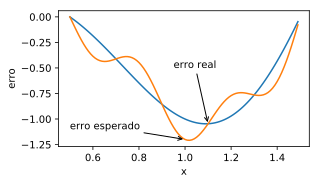

In [0]:
def f(x): return x * np.cos(np.pi * x)
def g(x): return f(x) + 0.2 * np.cos(5 * np.pi * x)

set_figsize((4.5, 2.5))
x = np.arange(0.5, 1.5, 0.01)
plot(x, [f(x), g(x)], 'x', 'erro')
annotate('erro esperado', (1.0, -1.2), (0.5, -1.1))
annotate('erro real', (1.1, -1.05), (0.95, -0.5))

### Desafios de otimização

Existem muitos desafios na otimização da aprendizagem profunda, como tratar os mínimos locais, os pontos de sela, e gradientes que "desaparecem" (*vanishing gradients*).
Vamos dar uma olhada em alguns deles.

#### Mínimos Locais

Para a função objetivo $f(x)$, se o valor de $f(x)$ em $x$ for menor que os valores de $f(x)$ em qualquer outro ponto na vizinhança de $x$, então $f(x)$ pode ser um mínimo local.
Se o valor de $f(x)$ em $x$ for o mínimo da função objetivo em todo o domínio, então $f(x)$ é considerado mínimo global.

Por exemplo, dada a função

$$ f (x) = x \cdot \text{cos} (\pi x)~\text{para} -1,0 \leq x \leq 2.0, $$

podemos aproximar o mínimo local e o mínimo global dessa função, como mostrado no gráfico a seguir.

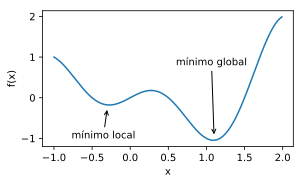

In [0]:
x = np.arange(-1.0, 2.0, 0.01)
plot(x, [f(x), ], 'x', 'f(x)')
annotate('mínimo local', (-0.3, -0.25), (-0.77, -1.0))
annotate('mínimo global', (1.1, -0.95), (0.6, 0.8))

A função objetiva dos modelos de *Deep Learning* geralmente tem muitos ótimos locais.
Quando a solução numérica de um problema de otimização está próxima do ótimo local, a solução numérica obtida pela iteração final pode apenas minimizar a função objetivo localmente, em vez de globalmente, à medida que o gradiente das soluções da função objetivo se aproxima ou se torna zero.
Apenas algum grau de ruído pode remover o parâmetro do mínimo local.
De fato, esta é uma das propriedades benéficas do [SGD](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.optimizer.SGD), onde a variação natural de gradientes sobre minibatches é capaz de remover os parâmetros dos mínimos locais.

#### Pontos de sela

Além dos mínimos locais, os pontos de sela são outro motivo para os gradientes "desaparecerem".
Um [ponto de sela](https://en.wikipedia.org/wiki/Saddle_point) é qualquer local onde os gradientes da função não existem, mas não é um mínimo global nem local.
Considere a função $f(x) = x^3$.
Sua primeira e segunda derivada deixam de existir quando $x = 0$.
Logo, a otimização pode parar no ponto, embora não seja um mínimo.

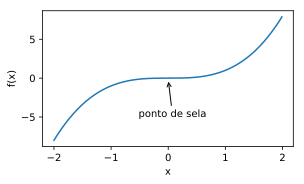

In [0]:
x = np.arange(-2.0, 2.0, 0.01)
plot(x, [x**3], 'x', 'f(x)')
annotate('ponto de sela', (0, -0.2), (-0.52, -5.0))

### Gradientes Desaparecidos

Provavelmente, o problema mais complexo na otimização das redes neurais profundas é o desaparecimento de gradientes (*vanishing gradients*).
Por exemplo, suponha que queremos minimizar a função $f(x) = \tanh(x)$ e começamos com $x = 4$.
Como podemos ver, o gradiente de $f$ está próximo de zero.
Mais especificamente $f'(x) = 1 - \tanh^2(x) $ e portanto $ f'(4) = 0,0013$.
Consequentemente, a otimização ficará presa por um longo tempo antes de começar a convergir.
Isso acaba sendo uma das razões pelas quais a formação de modelos de aprendizagem profunda foi bastante complicada antes da introdução da função de ativação ReLu.

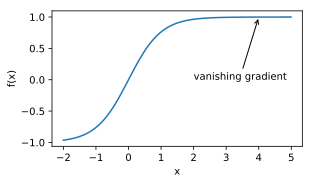

In [0]:
x = np.arange(-2.0, 5.0, 0.01)
plot(x, [np.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

Como vimos, a otimização para o aprendizado profundo é repleta de desafios.
Felizmente, existe uma gama robusta de algoritmos que funcionam bem e são fáceis de usar.
Veremos alguns desses algoritmos a seguir.



## Gradiente descendente (GD)

Vamos apresentar agora os conceitos básicos relativos ao gradiente descendente. Isto é breve por necessidade.
Embora este último seja raramente usado diretamente em aprendizado profundo, uma compreensão do gradiente descendente é a chave para entender os algoritmos estocásticos de gradiente descendente (*Stochastic Gradient Descent* -- SGD).
Por exemplo, o problema de otimização pode divergir devido a uma taxa de aprendizado excessivamente grande.
Esse fenômeno já pode ser visto no gradiente descendente.
Vamos começar com um caso especial simples.

### GD em uma dimensão

O GD em uma dimensão é um excelente exemplo para explicar porque o algoritmo pode reduzir o valor da função objetivo.
Considere alguma função diferenciável contínua definida nos números reais $f:\mathbb{R}\rightarrow \mathbb {R}$.
Usando uma expansão de Taylor para aproximar essa função, temos:

$$f(x + \epsilon) = f(x) + \epsilon f'(x) + O(\epsilon^2)$$
, onde $\epsilon$ é o erro.


Podemos então observar que, em uma aproximação inicial, $f(x + \epsilon)$ é dado pelo valor da função $f(x)$ e a primeira derivada $f '(x)$ em $x$.
Não podemos assumir que um valor pequeno de $\epsilon$ se movendo em direção à um valor negativo irá diminuir o erro da aproximação de $f$.
Para manter as coisas simples, escolhemos um tamanho de passo fixo $\eta> 0$ e escolhemos $\epsilon = -\eta f '(x)$.
Conectando isso na expansão de Taylor acima, temos:

$$f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + O(\eta^2 f'^2(x))$$

Se a derivada $f '(x) \neq 0$ não se perder, podemos convegir o processo já que $\eta f'^2(x) > 0$.
Além disso, podemos sempre escolher $\eta$ pequeno o suficiente para que os termos de ordem mais alta se tornem irrelevantes.
Chegamos então a seguinte fórmula:

$$f(x - \eta f'(x)) \lessapprox f(x)$$

Isso significa que, se usarmos

$$x \leftarrow x - \eta f'(x)$$

para iterar $ x $, o valor da função $f(x)$ pode diminuir.
Portanto, no gradiente descendente, primeiro escolhemos um valor inicial $x$ e uma constante $\eta> 0$ e depois os usamos para iterar continuamente $x$ até que a condição de parada seja atingida, por exemplo, quando a magnitude do gradiente $| f '(x) |$ é pequeno o suficiente ou o número de iterações atingiu um determinado valor.

No código abaixo, implementamos o algoritmo GD do zero.
Para simplificar, escolhemos a função objetivo $f(x) = x^2$ para ilustrar como implementar o gradiente descendente.
Embora saibamos de antemão que $x = 0$ é a solução para minimizar $f(x)$, usaremos essa função simples para analisar como $x$ é alterado usando o algoritmo GD.
Note que usamos $x = 10$ como valor inicial e assumimos $\eta = 0,2$.
Usando gradiente descendente para iterar $x$ por 10 vezes, podemos ver que, eventualmente, o valor de $x$ se aproxima da solução ótima.

epoch 10, x: 0.06046617599999997


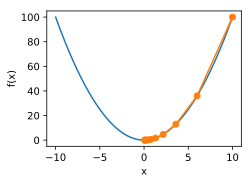

In [0]:
def f(x):     return x**2  # objective function
def gradf(x): return 2 * x # its derivative

def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * gradf(x)
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(0.2)

show_trace(res)

A taxa de aprendizado $\eta$ deve ser definida pelo pesquisador.
Se usarmos uma taxa de aprendizado muito pequena, isso fará com que $x$ seja atualizado muito lentamente, exigindo mais iterações para obter uma solução melhor.
Para mostrar esse efeito, considere o mesmo exemplo descrito anteriormentemas agora com $\eta = 0.05$.
Como podemos ver, mesmo após 10 etapas, ainda estamos muito longe da solução ideal.

epoch 10, x: 3.4867844009999995


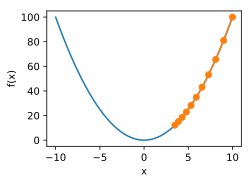

In [0]:
show_trace(gd(0.05))

Por outro lado, se usarmos uma taxa de aprendizado excessivamente alta, $\left | \eta f'(x) \right |$ pode ser muito grande para a fórmula de expansão de Taylor de primeira ordem.
Ou seja, o termo $\mathcal{O}(\eta^2 f '^2(x))$ pode se tornar significativo.
Nesse caso, não podemos garantir que a iteração de $x$ possa reduzir o valor de $f(x)$.
Por exemplo, quando definimos a taxa de aprendizado para $\eta = 1,1$, $x$ ultrapassa a solução ótima $ x = 0 $ e gradualmente diverge.

epoch 10, x: 61.917364224000096


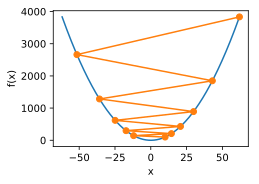

In [0]:
show_trace(gd(1.1))

Para ilustrar o que acontece com funções não convexas e seus múltiplos mínimos locais, considere o caso de $ f (x) = x \cdot \cos c x$.
Esta função tem infinitos mínimos locais.
Dependendo da nossa escolha de taxa de aprendizado e dependendo de quão bem condicionado o problema é, podemos acabar com uma das muitas soluções.
O exemplo abaixo ilustra como uma alta taxa de aprendizado levará a um mínimo local ruim.

epoch 10, x: -1.528165927635083


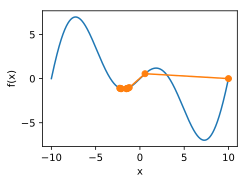

In [0]:
c = 0.15 * math.pi
def f(x):     return x*math.cos(c * x) 
def gradf(x): return math.cos(c * x) - c * x * math.sin(c * x)

show_trace(gd(2))

### GD em múltiplas dimensões

Agora que entendemos como o algoritmo de gradiente descendente funciona num cenário univariado, vamos considerar a situação em que $\mathbf{x} \in \mathbb{R}^d$.
Ou seja, a função objetiva $f: \mathbb{R}^d \to \mathbb{R} $ mapeia vetores em escalares.
Correspondentemente, seu gradiente é multivariado também.
É um vetor que consiste nas $d$ derivadas parciais:

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top$$

Cada derivada parcial $\frac{\partial f(\mathbf {x})}{\partial x_i}$ indica a taxa de variação de $f$ em $\mathbf{x}$ em relação à entrada $x_i$. 
Como antes, usamos uma aproximação de Taylor para funções multivariadas para obter uma idéia do que devemos fazer.
Em particular, temos:

$$f(\mathbf{x} + \mathbf{\epsilon}) = f(\mathbf{x}) + \mathbf{\epsilon}^\top \nabla f(\mathbf{x}) + O(\|\mathbf{\epsilon}\|^2).$$

Ao escolher uma taxa de aprendizado adequada $\eta> 0$, temos o algoritmo de gradiente descendente:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x})$$

Para ver como o algoritmo se comporta na prática, vamos construir uma função objetiva $f(\mathbf{x}) = x_1^ 2 + 2x_2^2$ com um vetor bidimensional $\mathbf{x} = [x_1, x_2]^\top$ como entrada e um escalar como saída.
Sabemos novamente que $\mathbf{x} = [0, 0]$ é a solução para minimizar $f(\mathbf{x})$.
O gradiente é dado por $\nabla f(\mathbf{x}) = [2x_1, 4x_2]^\top$.
Observaremos a trajetória de $\mathbf{x}$ pelo gradiente descendente a partir da posição inicial $[- 5, -2]$. Neste caso, faremos 20 iterações no algoritmo GD.

Observe o gráfico da trajetória da variável de otimização $\mathbf{x}$ para a taxa de aprendizado $\eta = 0.1$.
Podemos ver que depois de 20 passos o valor de $\mathbf{x}$ se aproxima de seu mínimo em $[0, 0]$. O progresso é razoavelmente bem comportado, embora bastante lento.

epoch 20, x1 -0.057646, x2 -0.000073


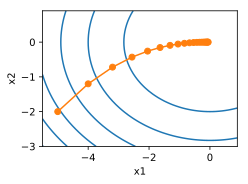

In [0]:
def train_2d(trainer):
    """Optimize a 2-dim objective function with a customized trainer."""
    # s1 and s2 are internal state variables and will 
    # be used later in the chapter
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def f(x1, x2): return x1 ** 2 + 2 * x2 ** 2   # objective
def gradf(x1, x2): return (2 * x1, 4 * x2)    # gradient 
def gd(x1, x2, s1, s2): 
    (g1, g2) = gradf(x1, x2)                  # compute gradient
    return (x1 -eta * g1, x2 -eta * g2, 0, 0) # update variables

eta = 0.1
show_trace_2d(f, train_2d(gd))

## *Stochastic Gradient Descent* (SGD)

Em *Deep Learning*, a função objetivo é geralmente a média das funções de perda para cada exemplo no conjunto de dados de treinamento.
Suponha $f_i(\boldsymbol{x})$, a função de perda de uma instância $i$ de treinamento.
Considere, também, que o conjunto de treino tenha $n$ instâncias.
Temos, então, a função de perda de toda a rede neural definida como:

$$f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\boldsymbol{x})$$

O gradiente da função objetivo em $\boldsymbol{x}$ é computado como:

$$\nabla f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x})$$

Se gradiente descendente for usado, o custo computacional para cada iteração de variável independente é $\mathcal{O}(n)$, e cresce linearmente com $n$.
Portanto, quando temos muitas amostras de treino, o custo do GD para cada iteração será muito alto.

O SGD reduz o custo computacional em cada iteração.
Em cada iteração do SGD, selecionamos aleatoriamente (uniformemente) um índice $i \in \{1, \ldots, n \}$ dentro os dados de treino e calculamos o gradiente $\nabla f_i (\boldsymbol{x})$ para atualizar $\boldsymbol{x}$:

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f_i(\boldsymbol{x})$$

Aqui, $\eta $ é a taxa de aprendizado (ou *learning rate*).
Podemos ver que o custo computacional para cada iteração cai de $\mathcal{O}(n)$ do GD para a constante $\mathcal{O}(1)$. Devemos mencionar que o SGD $\nabla f_i (\boldsymbol{x})$ é a estimativa não enviesada do gradiente $\nabla f (\boldsymbol{x})$.

$$\mathbb{E}_i \nabla f_i(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}) = \nabla f(\boldsymbol{x}).$$

Isso significa que, em média, o gradiente estocástico é uma boa estimativa do gradiente.

Vamos comparar o SGD com o GD  usando o mesmo exemplo anterior.
Neste caso, a função $f(\mathbf{x}) = x_1^ 2 + 2x_2^2$ tem solução ótima em $\mathbf{x} = [0, 0]$.
Usamos $\eta = 0.1$ e um total de 20 iterações, como anteriormente.

Nesta simulação, adicionamos um ruído aleatório com uma média 0 ao gradiente para simular um SGD.
Como podemos ver, a trajetória iterativa da variável independente no SGD é mais tortuosa do que na descida de gradiente. Isso se deve ao ruído adicionado no experimento, que reduziu a precisão do gradiente estocástico simulado. Na prática, esse ruído geralmente vem de exemplos individuais no conjunto de dados de treinamento.

epoch 20, x1 0.199206, x2 -0.094335


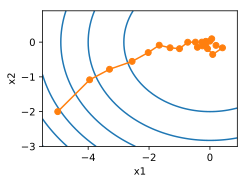

In [0]:
def train_2d(trainer):
    """Optimize a 2-dim objective function with a customized trainer."""
    # s1 and s2 are internal state variables and will 
    # be used later in the chapter
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def f(x1, x2): return x1 ** 2 + 2 * x2 ** 2   # objective
def gradf(x1, x2): return (2 * x1, 4 * x2)    # gradient
def sgd(x1, x2, s1, s2):                      # simulate noisy gradient
    (g1, g2) = gradf(x1, x2)                  # compute gradient
    (g1, g2) = (g1 + np.random.normal(0.1), g2 + np.random.normal(0.1))
    return (x1 -eta * g1, x2 -eta * g2, 0, 0) # update variables

eta = 0.1
show_trace_2d(f, train_2d(sgd))

## SGD em mini-*batch*

Em cada iteração, o GD usa todo o conjunto de dados de treinamento para calcular o gradiente, portanto, às vezes é chamado de gradiente descendente em *batch*.
Já o SGD apenas seleciona aleatoriamente um exemplo em cada iteração para calcular o gradiente.
Similar ao que já vimos, podemos realizar amostragem uniformemente aleatória em cada iteração para formar um mini-batchque é, então, usado para calcular o gradiente.
Esse é o SGD em mini-*batch*.

Suponha a função de objetivo $f(\boldsymbol{x}): \mathbb{R}^d \rightarrow \mathbb{R}$.
O intervalo de tempo antes do início da iteração é definido como 0.
A variável independente deste intervalo de tempo é $\boldsymbol{x}_0 \in \mathbb{R}^d$ e é geralmente obtida por inicialização aleatória.
Em cada passo de tempo subseqüente $t> 0$, o SGD em mini-*batch* usa amostragem uniformemente aleatória para obter um mini-*batch* $\mathcal {B}_t$ feito de exemplos do conjunto de treinamento.
Podemos usar amostragem com substituição ou amostragem sem reposição para obter um exemplo do mini-*batch*.
O primeiro método permite exemplos duplicados no mesmo mini-*batch*, enquanto o último, que é mais comumente usado, não permite amostras duplicadas.
Podemos usar qualquer um dos dois métodos para calcular o gradiente $\boldsymbol{g}_t$ da função objetivo em $\boldsymbol{x}_{t-1}$ com o mini-*batch* $\mathcal{B}_t$ no tempo $t$.

$$\boldsymbol{g}_t \leftarrow \nabla f_{\mathcal{B}_t}(\boldsymbol{x}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t}\nabla f_i(\boldsymbol{x}_{t-1})$$
, onde $|\mathcal{B}_t|$ é um hiper-parâmetro que representa o tamanho do *batch*, ou seja, o número de exemplos no mini-*batch*.

Assim como o SGD, o SGD em mini-*batch* $\boldsymbol{g}_t$ obtido por amostragem com substituição é também a estimativa imparcial do gradiente $\nabla(\boldsymbol{x}_{t-1})$.
Dada uma taxa de aprendizado $\eta_t$ (positiva), a iteração do SGD em mini-*batch* acontece da seguinte forma:

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \eta_t \boldsymbol{g}_t.$$

A variação do gradiente com base na amostragem aleatória não pode ser reduzida durante o processo iterativo, portanto, na prática, a taxa de aprendizado do SGD (mini-*batch*) pode se auto reduzir durante o processo, como $\eta_t = \eta t^\alpha$ (geralmente $\alpha = -1$ ou $-0.5$), $\eta_t = \eta \alpha^t$ (por exemplo, $\alpha = 0.95$), ou com um decaimento da taxa de aprendizagem uma vez por iteração ou após vários iterações.
Como resultado, a variação da taxa de aprendizado e do SGD (mini-*batch*) diminuirá.
GD sempre usa o gradiente verdadeiro da função objetivo durante a iteração, sem a necessidade de redução a taxa de aprendizagem.

O custo para calcular cada iteração é $\mathcal{O}(|\mathcal{B}|)$.
Quando o tamanho do *batch* é 1, o algoritmo é um SGD; quando o tamanho do *batch* é igual ao tamanho do dataset de treinamento, o algoritmo se passa por um GD.
Quando o tamanho do *batch* é pequeno, menos exemplos são usados em cada iteração, o que resultará em processamento paralelo e reduzirá a eficiência de uso da memória RAM.
Por outro lado, quando o tamanho do *batch* aumenta, cada gradiente do mini-*batch* pode conter mais informações redundantes.
Para obter uma solução melhor, precisamos ajustar bem o tamanho do *batch*.

### Implementação do zero

Abaixo, implementamos um SGD genérico, para que ser possamos mais a frente.

In [0]:
def sgd(params, states, hyperparams):
    for p in params:
        p[:] -= hyperparams['lr'] * p.grad

Quando o tamanho do *batch* é igual a 1500 (o número total de amostras de treino), usamos, na verdade, o GD para otimização.
Os parâmetros do modelo serão iterados apenas uma vez para cada época.
Como podemos ver, a tendência de queda do valor da função objetivo se estabilizou após 6 iterações.

loss: 0.249, 0.074 sec/epoch


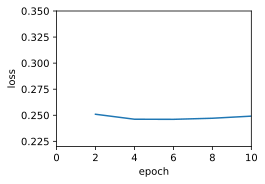

In [0]:
def train_ch10(trainer_fn, states, hyperparams, data_iter, 
               feature_dim, num_epochs=2):
    w = nd.random.normal(scale=0.01, shape=(feature_dim, 1))
    b = nd.zeros(1)
    w.attach_grad()
    b.attach_grad()
    net = lambda X: nd.dot(X, w) + b  # rede simples
    loss = squared_loss  # loss L2
    animator = Animator(xlabel='epoch', ylabel='loss', 
                        xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y).mean()  
            l.backward()
            trainer_fn([w, b], states, hyperparams)  # SGD
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))
    return timer.cum_times(), animator.Y[0]

def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch10(batch_size)
    return train_ch10(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

Quando o tamanho do *batch* é igual a 1, usamos, na verdade, o SGD para otimização.
No SGD, a variável independente (parâmetros do modelo) é atualizada sempre que uma amostra é processado no treinamento.
Assim, neste exemplo, ela atualizado 1500 vezes em uma época.
Como podemos ver, o declínio no valor da função objetiva desacelera após uma época.

Embora ambos os procedimentos tenham processado 1500 exemplos em uma época, o SGD consome mais tempo que o GD.
Isso ocorre porque o SGD executou mais iterações na variável independente em uma única época.

loss: 0.243, 0.332 sec/epoch


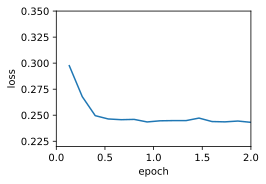

In [0]:
sgd_res = train_sgd(0.005, 1)

Quando o tamanho do *batch* é igual a 100, usamos, na verdade, o SGD em mini-*batch* para otimização.
O tempo de execução fica entre os tempos do GD e do SGD.

loss: 0.246, 0.013 sec/epoch


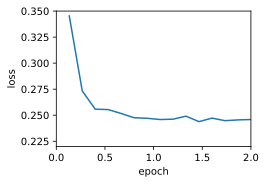

In [0]:
mini1_res = train_sgd(.4, 100)

Se reduzirmos o tamanho do *batch* para 10, o tempo aumenta já que ficamos menos eficientes, em termos computacionais, para processar cada *batch*.

loss: 0.248, 0.030 sec/epoch


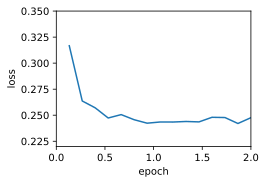

In [0]:
mini2_res = train_sgd(.05, 10)

Vamos, agora, comparamos os quatro experimentos executados anteriormente em termos de tempo versus *loss*.
Como podemos ver, o SGD demora mais tempo para convergir que o GD já que o processamento, exemplo por exemplo, não é eficiente.
O SGD em mini-*batch* é capaz de combinar a velocidade de convergência e a eficiência computacional.
Um SGD com *batch* de tamanho 10 é melhor que o SGD, enquando um SGD com *batch* de tamanho 100 supera o GD.

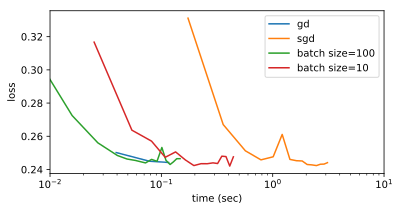

In [0]:
set_figsize([6, 3])
plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
        'time (sec)', 'loss', xlim=[1e-2, 10], 
        legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
plt.gca().set_xscale('log')

### Implementação direta

Em frameworks modernos, caso do MXNet, a implementação do SGD em mini-*batch* é feita de forma direta.
Especificamente, podemos usar a classe *Trainer* para chamar diferentes algoritmos de otimização, including o SGD em mini-*batch*.

No bloco a seguir, implementamos uma função de treinamento genérica e a usamos para repetir nosso último experimento, ou seja, um SGD em mini-*batch* usando 10 amostras por iteração.

loss: 0.252, 0.042 sec/epoch


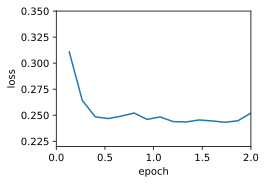

In [0]:
# função para treinar
def train_gluon_ch10(trainer_name, trainer_hyperparams, 
                     data_iter, num_epochs=2):
    # Initialization
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(
        net.collect_params(), trainer_name, trainer_hyperparams)
    loss = gluon.loss.L2Loss()
    animator = Animator(xlabel='epoch', ylabel='loss', 
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(X.shape[0])
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))
    return timer.cum_times(), animator.Y[0]
  
data_iter, _ = get_data_ch10(10)
train_gluon_ch10('sgd', {'learning_rate': 0.05}, data_iter);

## Momentum

Agora, vamos considerar uma função objetiva $ f(\boldsymbol{x}) = 0.1x_1^2 + 2x_2^2$, cuja entrada e saída são um vetor bidimensional $\boldsymbol{x} = [x_1, x_2]$ e um escalar, respectivamente.
Em contraste com GD, aqui, o coeficiente $x_1^2$ é reduzido de $1$ para $0.1$. Vamos implementar o GD com base nessa função objetivo e demonstrar a trajetória iterativa da variável independente usando a taxa de aprendizado de $0.4$.

epoch 20, x1 -0.943467, x2 -0.000073


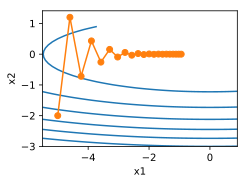

In [0]:
# função usada para treinar
def train_2d(trainer):
    """Optimize a 2-dim objective function with a customized trainer."""
    # s1 and s2 are internal state variables and will 
    # be used later in the chapter
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

Como podemos ver, a inclinação da função objetivo tem um valor absoluto maior na direção vertical (direção do eixo $x_2$) do que na direção horizontal (direção do eixo $x_1$).
Portanto, dada a taxa de aprendizado, o uso do GD para iteração fará com que a variável independente se mova mais na direção vertical do que na horizontal.
Portanto, precisamos de uma pequena taxa de aprendizado para impedir que a variável independente ultrapasse a solução ideal para a função objetiva na direção vertical.
No entanto, isso fará com que a variável independente se mova mais lentamente em direção à solução ideal na direção horizontal.

Com uma a taxa de aprendizado um pouco maior, a variável independente irá continuamente ultrapassar a solução ótima na direção vertical e gradualmente divergir, como é mostrado abaixo.



epoch 20, x1 -0.387814, x2 -1673.365109


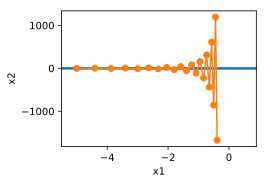

In [0]:
eta = 0.6
show_trace_2d(f_2d, train_2d(gd_2d))

O método momentum foi proposto para resolver esse problema.
Suponha uma variável independente $\mathbf{x}_t$ e a taxa de aprendizagem $\eta_t$, ambas no tempo $t$.
No tempo$0$, o momento cria a variável velocidade $\mathbf{v}_0$ e a inicializa com zero.
No intervalo de tempo $t>0$, o algoritmo de momentum modifica o processo de convergência da seguinte forma:

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \gamma \mathbf{v}_{t-1} + \eta_t \mathbf{g}_t \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \mathbf{v}_t
\end{aligned}
$$
, onde $\gamma$ ($0 \leq \gamma <1$) é o hiper-parâmetro chamadno momentum . Quando $\gamma = 0$, momentum é equivalente a um SGD em mini-*batch*.

Antes de explicar os princípios matemáticos por trás do método do momentum, olhemos a trajetória iterativa do gradiente usando o momentum.

epoch 20, x1 -0.062843, x2 0.001202


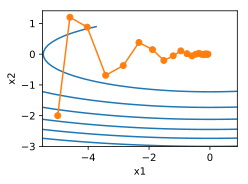

In [0]:
# função que implementa o momentum em 2d
def momentum_2d(x1, x2, v1, v2):
    v1 = gamma * v1 + eta * 0.2 * x1
    v2 = gamma * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2

eta, gamma = 0.4, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d))

Como podemos ver, quando usamos uma menor taxa de aprendizado ($\eta = 0.4$) e um momentum ($\gamma = 0.5$), o momentum se move mais suavemente na direção vertical enquanto se aproxima da solução ótima mais rapidamente na direção horizontal.
Agora, quando usamos uma taxa de aprendizado maior ($\eta = 0,6$), a variável independente não vai mais divergir.

epoch 20, x1 0.007188, x2 0.002553


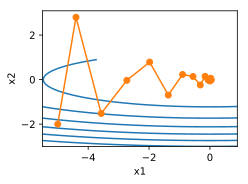

In [0]:
eta = 0.6
show_trace_2d(f_2d, train_2d(momentum_2d))

### A variável $\mathbf{v_t}$

Para entender o método momentum, podemos expandir a variável velocidade ao longo do tempo:

$$
\begin{aligned}
\mathbf{v}_t &= \eta_t \mathbf{g}_t + \gamma \mathbf{v}_{t-1}, \\
             &= \eta_t \mathbf{g}_t + \gamma \eta_{t-1} \mathbf{g}_{t-1} + \gamma\mathbf{v}_{t-1}, \\
             &\ldots\\
             &= \eta_t \mathbf{g}_t + \gamma \eta_{t-1} \mathbf{g}_{t-1} + \ldots +  \gamma\eta_1\mathbf g_1. \\
\end{aligned}
$$

Como podemos ver, $\mathbf v_t$ é uma soma ponderada sobre todos os gradientes do passado multiplicados pela taxa de aprendizagem correspondente.

O bloco de código a seguir mostra os valores das últimas 40 etapas sob vários $\gamma$ s.

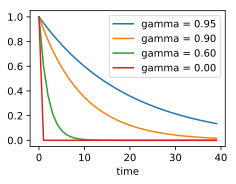

In [0]:
gammas = [0.95, 0.9, 0.6, 0]
set_figsize((3.5, 2.5))
for gamma in gammas:
    x = nd.arange(40).asnumpy()
    plt.plot(x, gamma ** x, label='gamma = %.2f'%gamma)
plt.xlabel('time')
plt.legend();

Um pequeno $\gamma$ permitirá que a variável de velocidade se concentre em gradientes mais recentes, enquanto um valor maior de $\gamma$ fará com que gradientes antigos tenham maior influência na varíavel $\mathbf{v}$.
Comparado com o GD, o momentum fará com que as atualizações de peso sejam mais consistentes ao longo do tempo.

### Implementação do zero

Comparado com SGD em mini-*batch*, o método momentum precisa manter uma variável de velocidade para cada variável independente. Na implementação abaixo, usamos uma variável *states* para representar a variável velocidade.

Quando definimos o hiper-parâmetro momentum em 0.5, o método pode ser visto como um SGD em mini-*batch*: o gradiente é a média ponderada (em 0.5) dos últimos passos de tempo.

loss: 0.244, 0.028 sec/epoch


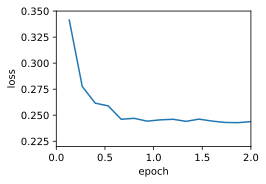

In [0]:
# função usada para treinar
def train_ch10(trainer_fn, states, hyperparams, data_iter, 
               feature_dim, num_epochs=2):
    w = nd.random.normal(scale=0.01, shape=(feature_dim, 1))
    b = nd.zeros(1)
    w.attach_grad()
    b.attach_grad()
    net = lambda X: nd.dot(X, w) + b  # rede simples
    loss = squared_loss  # loss L2
    animator = Animator(xlabel='epoch', ylabel='loss', 
                        xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y).mean()  
            l.backward()
            trainer_fn([w, b], states, hyperparams)  # SGD
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))
    return timer.cum_times(), animator.Y[0]

# função para iniciar o estado do momentum
def init_momentum_states(feature_dim):
    v_w = nd.zeros((feature_dim, 1))
    v_b = nd.zeros(1)
    return (v_w, v_b)

# função que implementa momentum do zero
# variavel states representa a velocidade v
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v[:] = hyperparams['momentum'] * v + hyperparams['lr'] * p.grad
        p[:] -= v

# função que chama o treino
def train_momentum(lr, momentum, num_epochs=2):
    train_ch10(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter, 
                   feature_dim, num_epochs)
    
data_iter, feature_dim = get_data_ch10(batch_size=10)
train_momentum(0.02, 0.5)

### Implementação Direta

Em frameworks modernos, caso do MXNet, a implementação do método do momentum é feita de forma direta.
Como já visto, podemos usar a classe *Trainer* para chamar diferentes algoritmos de otimização, including o SGD com momentum.

No bloco a seguir, implementamos uma função de treinamento genérica e a usamos para rodar um experimento usando SGD com momentum ($\eta=0.004$ e $\gamma=0.9$).

loss: 0.243, 0.027 sec/epoch


([0.024998188018798828,
  0.05540132522583008,
  0.08568596839904785,
  0.11963939666748047,
  0.14383292198181152,
  0.17229819297790527,
  0.1979541778564453,
  0.2225663661956787,
  0.24584460258483887,
  0.2701141834259033,
  0.2958495616912842,
  0.3290867805480957,
  0.35746240615844727,
  0.38117384910583496,
  0.4086928367614746],
 [0.34876500292619067,
  0.2741715459426244,
  0.25357169439395266,
  0.24795999511082967,
  0.24637689963976542,
  0.24521529455979665,
  0.24752899579207102,
  0.24448919749259948,
  0.2504230344692866,
  0.2435682578285535,
  0.24249797916412352,
  0.243545131166776,
  0.243069003423055,
  0.2430639774799347,
  0.24278788934151332])

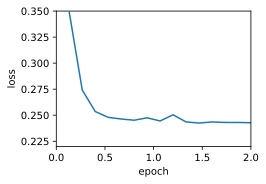

In [0]:
def train_gluon_ch10(trainer_name, trainer_hyperparams, 
                     data_iter, num_epochs=2):
    # Initialization
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(
        net.collect_params(), trainer_name, trainer_hyperparams)
    loss = gluon.loss.L2Loss()
    animator = Animator(xlabel='epoch', ylabel='loss', 
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(X.shape[0])
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))
    return timer.cum_times(), animator.Y[0]

train_gluon_ch10('sgd', {'learning_rate': 0.004, 'momentum': 0.9}, 
                 data_iter)

## Adagrad

Nos algoritmos de otimização anteriormente, cada elemento da função objetivo usa a mesma taxa de aprendizado no mesmo intervalo de tempo.
Por exemplo, se assumirmos que a variável independente é vetores bidimensional $[x_1, x_2]^\top$, cada elemento no vetor usa a mesma taxa de aprendizado no processo de otimização.
No caso do GD, por exemplo, a taxa de aprendizado $\eta$ é usada na otimização de $x_1$ e $x_2$:

$$
x_1 \leftarrow x_1 - \eta \frac{\partial{f}}{\partial{x_1}}, \quad
x_2 \leftarrow x_2 - \eta \frac{\partial{f}}{\partial{x_2}}.
$$

Anteriormente, vimos que, quando há uma grande diferença entre os valores de gradiente de $x_1$ e $x_2$, uma taxa de aprendizagem pequena deve ser selecionada para que a otimização não diverge a favor da variável com maior gradientes.
Porém, isso faz com o processo de aprendizado seja lento, principalmente para a variável com menos gradientes.
Nesta seção, vamos introduzir Adagrad, um algoritmo que ajusta a taxa de aprendizagem de acordo com o valor do gradiente da variável para eliminar problemas causados quando uma taxa de aprendizado é usada.

### O Algoritmo

O algoritmo usa uma variável acumulativa $\boldsymbol{s}_t$ obtida diretamente dos gradiente $\boldsymbol{g}_t$.
No passo de tempo 0, Adagrad inicializa cada elemento em $\boldsymbol{s}_0$ como 0.
No passo de tempo $t$, a variável $\boldsymbol{s}_t$ é atualizada da seguinte forma:

$$\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t,$$

Aqui, $\odot$ é o símbolo da multiplicação por elemento.
Em seguida, usamos $\boldsymbol{s}$ para reajustar a taxa de aprendizado $\eta$ de cada elemento:

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,$$

Aqui, $\eta$ é a taxa de aprendizado, enquanto $\epsilon$ é uma constante pequena (como $10^{- 6}$) adicionada para manter a estabilidade numérica.
Aqui, as operações de raiz quadrada, divisão e multiplicação são todas operações de elementos.
Cada elemento na variável independente da função objetivo terá sua própria taxa de aprendizado após as operações por elementos.

Como $\boldsymbol{s}_t$ depende dos gradiente e é parte do denominador de taxa de aprendizado final, se um elemento na variável independente da função objetivo tiver um gradiente maior, a taxa de aprendizado desse elemento cairá mais rapidamente.
Como esperado, se o gradiente for pequeno, sua taxa de aprendizado diminuirá mais lentamente.
O problema disso é que se a taxa de aprendizado diminui muito rapidamenteem iterações iniciais, o algoritmo do Adagrad pode ter dificuldade em encontrar uma solução útil, porque a taxa de aprendizado será muito pequena nos estágios finais da iteração.

Abaixo, continuaremos a usar a função objetivo $f(\boldsymbol{x}) = 0.1x_1^2 + 2x_2^2$ como exemplo para observar a trajetória da variável independente quando otimizada pelo Adagrad.
Vamos implementar o Adagrad usando a mesma taxa de aprendizado de 0.4.
Como podemos ver, a trajetória da aprendizagem é mais suave.
No entanto, devido ao efeito cumulativo de $\boldsymbol{s}_t$, a taxa de aprendizado decai continuamente, portanto a variável independente não se move tanto durante os estágios finais da iteração.

epoch 20, x1 -2.382563, x2 -0.158591


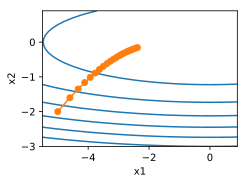

In [0]:
def adagrad_2d(x1, x2, s1, s2):
    # The first two terms are the independent variable gradients
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
show_trace_2d(f_2d, train_2d(adagrad_2d))

Agora, vamos aumentar a taxa de aprendizado para $2$. Como podemos ver, a variável independente se aproxima da solução ótima mais rapidamente.

epoch 20, x1 -0.002295, x2 -0.000000


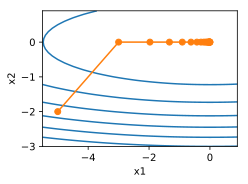

In [0]:
eta = 2
show_trace_2d(f_2d, train_2d(adagrad_2d))

### Implementação do Scratch

Como o método momentum, Adagrad precisa de uma variável auxiliar.
Por isso, usamos a mesma ideia de *states* do algoritmo momentum para implementar o Adagrad.

Aqui, usamos uma taxa de aprendizado de $0.1$ para treinar o modelo.

loss: 0.243, 0.037 sec/epoch


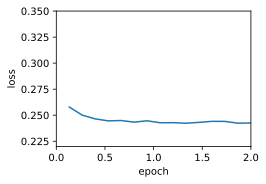

In [0]:
def init_adagrad_states(feature_dim):
    s_w = nd.zeros((feature_dim, 1))
    s_b = nd.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s[:] += p.grad.square()
        p[:] -= hyperparams['lr'] * p.grad / (s + eps).sqrt()
        
data_iter, feature_dim = get_data_ch10(batch_size=10)
train_ch10(adagrad, init_adagrad_states(feature_dim), 
               {'lr': 0.1}, data_iter, feature_dim);

### Implementação Direta

Em frameworks modernos, caso do MXNet, a implementação do método do momentum é feita de forma direta.
Como já visto, podemos usar a classe *Trainer* para chamar diferentes algoritmos de otimização, including o Adagrad.

No bloco a seguir, implementamos uma função de treinamento genérica e a usamos para rodar um experimento usando Adagrad ($\eta=0.01$).

loss: 0.243, 0.040 sec/epoch


([0.031824350357055664,
  0.07069587707519531,
  0.10488224029541016,
  0.13756418228149414,
  0.17668986320495605,
  0.22719240188598633,
  0.2647221088409424,
  0.3024756908416748,
  0.34212422370910645,
  0.38138771057128906,
  0.4249916076660156,
  0.4765608310699463,
  0.5194358825683594,
  0.5584406852722168,
  0.6026175022125244],
 [0.28214828900496164,
  0.25065399666627247,
  0.2454595215221246,
  0.24406582073370617,
  0.2472508137623469,
  0.24400552173455556,
  0.2438927175203959,
  0.24277654713392258,
  0.24362247407436372,
  0.24286507612466812,
  0.2438921275138855,
  0.24250747074683507,
  0.24482427696386974,
  0.24238047095139822,
  0.24313836669921876])

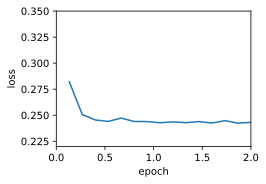

In [26]:
# função para treinar
def train_gluon_ch10(trainer_name, trainer_hyperparams, 
                     data_iter, num_epochs=2):
    # Initialization
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(
        net.collect_params(), trainer_name, trainer_hyperparams)
    loss = gluon.loss.L2Loss()
    animator = Animator(xlabel='epoch', ylabel='loss', 
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(X.shape[0])
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))
    return timer.cum_times(), animator.Y[0]

train_gluon_ch10('adagrad', {'learning_rate': 0.1}, data_iter)

## RMSProp

Como visto, no algoritmo Adagrad, a taxa de aprendizado de cada variável independente da função objetivo diminui (ou permanece inalterada) durante as iterações porque a variável $\mathbf{s}_t$ ajusta esta taxa de aprendizagem.
O problema disso é que quando a taxa de aprendizado diminui muito rapidamente durante iterações iniciais, o algoritmo do Adagrad pode ter dificuldade em encontrar uma boa solução, já que a taxa de aprendizado será muito pequena nas iterações finais.
Para resolver este problema, o algoritmo RMSProp fez uma pequena modificação no Adagrad.

### O Algoritmo

Ao contrário de Adagrad, o RMSProp se baseia na média móvel exponencialmente ponderada (*Exponentially Weighted Moving Average* - EWMA) para atualizar a variável $\mathbf{s}$.
Nesse caso, dado uma váriável $\gamma$ ($0 \leq \gamma < 1$), $\mathbf{s}_t$ é atualizado da seguinte forma:

$$\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t \odot \mathbf{g}_t. $$

O RMSProp reajusta a taxa de aprendizado igual ao Adagrad:

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t, $$
, one $\eta$ é a taxa de aprendizado, e $\epsilon $ é uma constante adicionada para garantir estabilidade numérica.

Abaixo, visualizamos o efeito de diferentes valores de $\gamma$s ao longo do tempo.

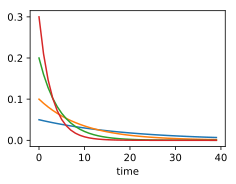

In [0]:
gammas = [0.95, 0.9, 0.8, 0.7]
set_figsize((3.5, 2.5))
for gamma in gammas:
    x = nd.arange(40).asnumpy()
    plt.plot(x, (1-gamma) * gamma ** x, label='gamma = %.2f'%gamma)
plt.xlabel('time');

### Implementação do zero

Usaremos novamente a função objetivo $f(\mathbf {x}) = 0.1x_1^2 + 2x_2^2$ para analisar o algoritmo RMSProp.
Quando usamos Adagrad para otimizar essa função com uma taxa de aprendizado de 0.4, a convergência ficou mais lenta nos passos finais da iteração.
No entanto, com a mesma taxa de aprendizado, o RMSProp pode encontrar a solução ideal mais rapidamente.

epoch 20, x1 -0.010599, x2 0.000000


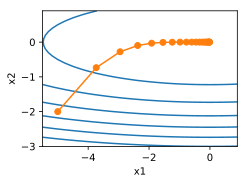

In [0]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
show_trace_2d(f_2d, train_2d(rmsprop_2d))

Em seguida, implementamos o RMSProp com a fórmula no algoritmo.
Definimos a taxa inicial de aprendizado para 0.01 e o hiperparâmetro $\gamma$ para 0.9.

loss: 0.244, 0.041 sec/epoch


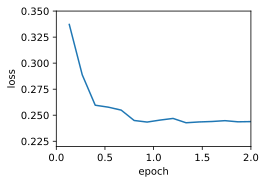

In [22]:
def init_rmsprop_states(feature_dim):
    s_w = nd.zeros((feature_dim, 1))
    s_b = nd.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        s[:] = gamma * s + (1 - gamma) * p.grad.square()
        p[:] -= hyperparams['lr'] * p.grad / (s + eps).sqrt()
        
data_iter, feature_dim = get_data_ch10(batch_size=10)
train_ch10(rmsprop, init_rmsprop_states(feature_dim), 
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

### Implementação Direta

Em frameworks modernos, caso do MXNet, a implementação do método do momentum é feita de forma direta.
Como já visto, podemos usar a classe *Trainer* para chamar diferentes algoritmos de otimização, including o RMSProp.

No bloco a seguir, implementamos uma função de treinamento genérica e a usamos para rodar um experimento usando Adagrad ($\eta=0.01$ e $\gamma=0.9$).

loss: 0.246, 0.031 sec/epoch


([0.025481224060058594,
  0.0708155632019043,
  0.1061406135559082,
  0.1321544647216797,
  0.16814422607421875,
  0.19653987884521484,
  0.22452616691589355,
  0.24867773056030273,
  0.2869682312011719,
  0.31204938888549805,
  0.3393256664276123,
  0.37061119079589844,
  0.4064290523529053,
  0.4396324157714844,
  0.4679844379425049],
 [0.34775775265693665,
  0.29841687381267545,
  0.26346907297770183,
  0.25110769669214883,
  0.24898495237032572,
  0.24609025303522747,
  0.2439768815835317,
  0.24305493772029876,
  0.2440687523285548,
  0.24582742553949355,
  0.24399218980471293,
  0.24280872269471487,
  0.2447718303700288,
  0.24229735320806503,
  0.24561191856861114])

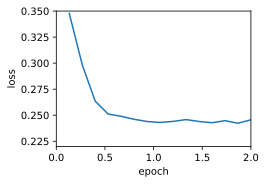

In [23]:
# função para treinar
def train_gluon_ch10(trainer_name, trainer_hyperparams, 
                     data_iter, num_epochs=2):
    # Initialization
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(
        net.collect_params(), trainer_name, trainer_hyperparams)
    loss = gluon.loss.L2Loss()
    animator = Animator(xlabel='epoch', ylabel='loss', 
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(X.shape[0])
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))
    return timer.cum_times(), animator.Y[0]

train_gluon_ch10('rmsprop', {'learning_rate': 0.01, 'gamma1': 0.9},
                 data_iter)

## Adadelta

Além do RMSProp, o Adadelta é outro algoritmo de otimização que ajuda a melhorar as chances de encontrar boas soluções em fases finais do processo de otimização, o que é difícil de fazer quando se usa o algoritmo Adagrad.
O interessante é que não há o hiper-parâmetro de taxa de aprendizado no algoritmo Adadelta.

### O Algoritmo

Como o RMSProp, o algoritmo Adadelta também usa a variável $\boldsymbol{s}_t$, que são inicializados com 0 no tempo $t=0$.
Dado o hiper-parâmetro $0 \leq \rho < 1$, a atualização de $\boldsymbol{s}_t$ em $t>0$, acontece como no RMSProp:

$$\boldsymbol{s}_t \leftarrow \rho \boldsymbol{s}_{t-1} + (1 - \rho) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

Ao contrário de RMSProp, Adadelta mantém uma variável de estado adicional, $\Delta \boldsymbol{x}_t$ cujos elementos também são inicializados como 0 no tempo 0.
Usamos $\Delta \boldsymbol{x}_{t-1}$ para calcular a variação da variável independente:

$$ \boldsymbol{g}_t' \leftarrow \sqrt{\frac{\Delta\boldsymbol{x}_{t-1} + \epsilon}{\boldsymbol{s}_t + \epsilon}}   \odot \boldsymbol{g}_t, $$
, onde $\epsilon$ é uma constante adicionada para manter a estabilidade numérica.

Em seguida, atualizamos a variável independente:

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}'_t. $$

Finalmente, atualizamos os valores de $\Delta \boldsymbol{x}$:

$$\Delta\boldsymbol{x}_t \leftarrow \rho \Delta\boldsymbol{x}_{t-1} + (1 - \rho) \boldsymbol{g}'_t \odot \boldsymbol{g}'_t. $$

Como podemos ver, se a variável $\epsilon$ for desconsiderada, o Adadelta difere do RMSProp somente no usa de $\sqrt{\Delta \boldsymbol{x}_{t-1}} $.

### Implementação do zero

Adadelta precisa manter duas variáveis de estado para cada variável independente, $\boldsymbol{s}_t$ e $\Delta \boldsymbol{x}_t$.
Usamos a ideia da variável *states*, introduzida anteriormente, para implementar o Adadelta abaixo.

Neste exemplo, treinamos o modelo com o hiperparâmetro $\rho = 0.9$.

loss: 0.243, 0.046 sec/epoch


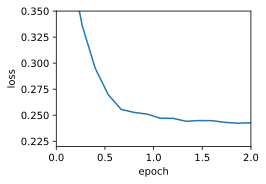

In [25]:
# função usada para treinar
def train_ch10(trainer_fn, states, hyperparams, data_iter, 
               feature_dim, num_epochs=2):
    w = nd.random.normal(scale=0.01, shape=(feature_dim, 1))
    b = nd.zeros(1)
    w.attach_grad()
    b.attach_grad()
    net = lambda X: nd.dot(X, w) + b  # rede simples
    loss = squared_loss  # loss L2
    animator = Animator(xlabel='epoch', ylabel='loss', 
                        xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y).mean()  
            l.backward()
            trainer_fn([w, b], states, hyperparams)  # SGD
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))
    return timer.cum_times(), animator.Y[0]

def init_adadelta_states(feature_dim):
    s_w, s_b = nd.zeros((feature_dim, 1)), nd.zeros(1)
    delta_w, delta_b = nd.zeros((feature_dim, 1)), nd.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s[:] = rho * s + (1 - rho) * p.grad.square()
        g = ((delta + eps).sqrt() / (s + eps).sqrt()) * p.grad
        p[:] -= g
        delta[:] = rho * delta + (1 - rho) * g * g
        
data_iter, feature_dim = get_data_ch10(batch_size=10)
train_ch10(adadelta, init_adadelta_states(feature_dim), 
               {'rho': 0.9}, data_iter, feature_dim);

### Implementação Direta

Em frameworks modernos, caso do MXNet, a implementação do método do momentum é feita de forma direta.
Como já visto, podemos usar a classe *Trainer* para chamar diferentes algoritmos de otimização, including o Adadelta.

No bloco a seguir, implementamos uma função de treinamento genérica e a usamos para rodar um experimento usando Adadelta ($\rho=0.9$).

loss: 0.244, 0.058 sec/epoch


([0.053922414779663086,
  0.11530327796936035,
  0.17107629776000977,
  0.22762155532836914,
  0.28772735595703125,
  0.34534549713134766,
  0.4049832820892334,
  0.4690887928009033,
  0.5212938785552979,
  0.5833959579467773,
  0.6476325988769531,
  0.7068309783935547,
  0.7633967399597168,
  0.8165798187255859,
  0.8753118515014648],
 [0.3470375503698985,
  0.2969404757420222,
  0.26973161764939624,
  0.25662274126211804,
  0.2519220629533132,
  0.2495910708506902,
  0.24581686770915986,
  0.2449687842329343,
  0.2437075228691101,
  0.24448366781075795,
  0.24595746459563572,
  0.24281064279874165,
  0.24275042974948882,
  0.2444301413098971,
  0.24356740339597066])

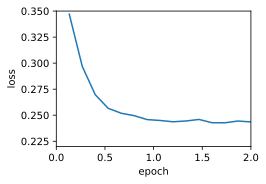

In [0]:
# função para treinar
def train_gluon_ch10(trainer_name, trainer_hyperparams, 
                     data_iter, num_epochs=2):
    # Initialization
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(
        net.collect_params(), trainer_name, trainer_hyperparams)
    loss = gluon.loss.L2Loss()
    animator = Animator(xlabel='epoch', ylabel='loss', 
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(X.shape[0])
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))
    return timer.cum_times(), animator.Y[0]

train_gluon_ch10('adadelta', {'rho': 0.9}, data_iter)

## Adam

Criado com base no RMSProp, Adam também usa o conceito de EWMA em seu algoritmo.

Adam usa duas variáveis auxilias $\boldsymbol{v}_t$ e $\boldsymbol{s}_t$,  ambas inicializados em 0 no tempo 0.
Dado um hiper-parâmetro $0\leq \beta_1 < 1$ (o autor do algoritmo sugere um valor de 0.9), a variável de momentum $\boldsymbol{v}_t$ no passo de tempo $t$ é atualizada da seguinte forma:

$$\boldsymbol{v}_t \leftarrow \beta_1 \boldsymbol{v}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t. $$

Assim como no RMSProp, dado o hiper-parâmetro $0 \leq \beta_2 < 1$ (o autor do algoritmo sugere um valor de 0,999), a variável $\boldsymbol{s}_t$ é atualizada da seguinte forma:

$$\boldsymbol{s}_t \leftarrow \beta_2 \boldsymbol{s}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

Uma normalização é então realiada pelo algoritmo Adam:

$$\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_1^t}, $$

$$\hat{\boldsymbol{s}}_t \leftarrow \frac{\boldsymbol{s}_t}{1 - \beta_2^t}. $$

Em seguida, o algoritmo Adam usará as variáveis normalizadas para reajustar a taxa de aprendizado:

$$\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{v}}_t}{\sqrt{\hat{\boldsymbol{s}}_t} + \epsilon},$$
, one $\eta $ é a taxa de aprendizado, e $\epsilon$ é uma constante adicionada para manter a estabilidade numérica.

Assim como para Adagrad, RMSProp, e Adadelta, cada elemento na variável independente da função objetivo tem sua própria taxa de aprendizado.
Finalmente, usamos $\boldsymbol{g}_t'$ para atualizar e convergir o modelo:

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'. $$

### Implementação do zero

Adam precisa manter duas variáveis de estado para cada variável independente, $\boldsymbol{v}_t$ e $\boldsymbol{s}_t$.
Usamos a ideia da variável *states*, introduzida anteriormente, para implementar o Adam abaixo.

Neste exemplo, treinamos o modelo usando Adam com o hiper-parâmetro $\eta = 0.01$.

loss: 0.243, 0.047 sec/epoch


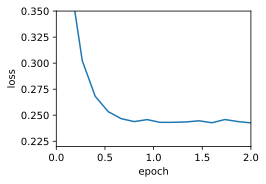

In [28]:
# função usada para treinar
def train_ch10(trainer_fn, states, hyperparams, data_iter, 
               feature_dim, num_epochs=2):
    w = nd.random.normal(scale=0.01, shape=(feature_dim, 1))
    b = nd.zeros(1)
    w.attach_grad()
    b.attach_grad()
    net = lambda X: nd.dot(X, w) + b  # rede simples
    loss = squared_loss  # loss L2
    animator = Animator(xlabel='epoch', ylabel='loss', 
                        xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y).mean()  
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))
    return timer.cum_times(), animator.Y[0]

def init_adam_states(feature_dim):
    v_w, v_b = nd.zeros((feature_dim, 1)), nd.zeros(1)
    s_w, s_b = nd.zeros((feature_dim, 1)), nd.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad
        s[:] = beta2 * s + (1 - beta2) * p.grad.square()
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p[:] -= hyperparams['lr'] * v_bias_corr / (s_bias_corr.sqrt() + eps)
    hyperparams['t'] += 1
    
data_iter, feature_dim = get_data_ch10(batch_size=10)
train_ch10(adam, init_adam_states(feature_dim), 
           {'lr': 0.01, 't': 1}, data_iter, feature_dim);

### Implementação Direta

Em frameworks modernos, caso do MXNet, a implementação do método do momentum é feita de forma direta.
Como já visto, podemos usar a classe *Trainer* para chamar diferentes algoritmos de otimização, including o Adam.

No bloco a seguir, implementamos uma função de treinamento genérica e a usamos para rodar um experimento usando Adagrad ($\eta=0.01$).

loss: 0.243, 0.029 sec/epoch


([0.025896310806274414,
  0.05100536346435547,
  0.07698750495910645,
  0.10987186431884766,
  0.13376712799072266,
  0.15695595741271973,
  0.1823563575744629,
  0.21630215644836426,
  0.24174189567565918,
  0.26738476753234863,
  0.29878950119018555,
  0.34534502029418945,
  0.3751351833343506,
  0.4032742977142334,
  0.4393160343170166],
 [0.3719948582649231,
  0.3040110632578532,
  0.2692484378417333,
  0.2547710168361664,
  0.24900668853521346,
  0.24624648797512055,
  0.24291182561715444,
  0.24266165979703266,
  0.2429737254579862,
  0.2585105230808258,
  0.2443465682466825,
  0.24648849884668986,
  0.2487063371340434,
  0.24625833050409954,
  0.24290504356225331])

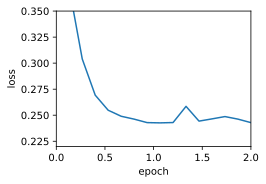

In [29]:
# função para treinar
def train_gluon_ch10(trainer_name, trainer_hyperparams, 
                     data_iter, num_epochs=2):
    # Initialization
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(
        net.collect_params(), trainer_name, trainer_hyperparams)
    loss = gluon.loss.L2Loss()
    animator = Animator(xlabel='epoch', ylabel='loss', 
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(X.shape[0])
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             evaluate_loss(net, data_iter, loss))
                timer.start()
    print('loss: %.3f, %.3f sec/epoch'%(animator.Y[0][-1], timer.avg_time()))
    return timer.cum_times(), animator.Y[0]

train_gluon_ch10('adam', {'learning_rate': 0.01}, data_iter)